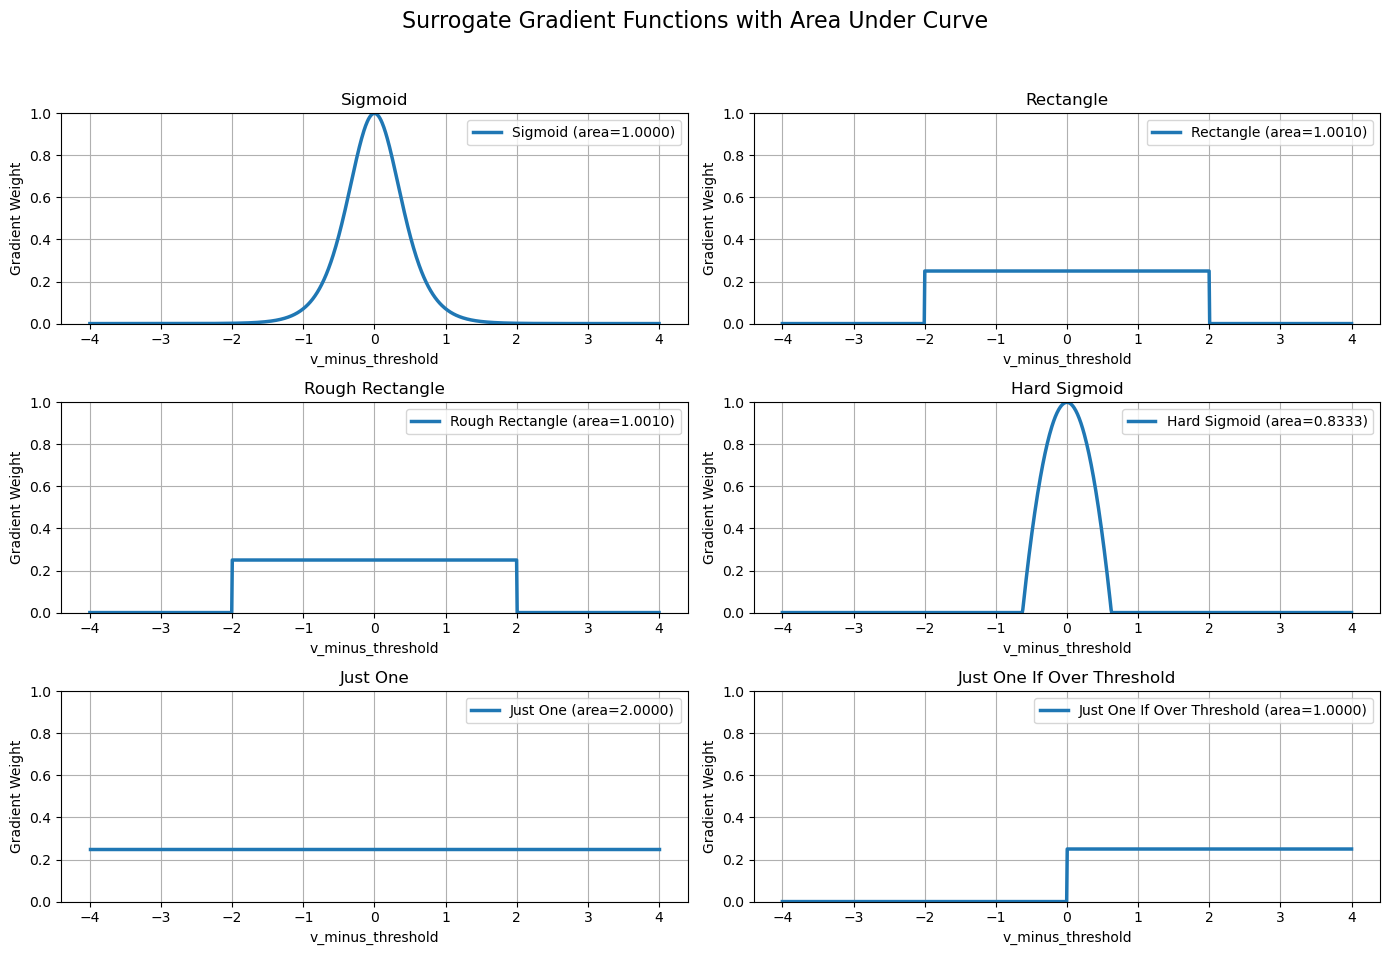

📐 Area under each surrogate gradient curve:
- Sigmoid: 1.000000
- Rectangle: 1.001001
- Rough Rectangle: 1.001001
- Hard Sigmoid: 0.833350
- Just One: 2.000000
- Just One If Over Threshold: 1.000000


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson

# surrogate 종류
surrogate_names = {
    1: "Sigmoid",
    2: "Rectangle",
    3: "Rough Rectangle",
    4: "Hard Sigmoid",
    5: "Just One",
    6: "Just One If Over Threshold"
}

# 설정
v = torch.linspace(-4, 4, steps=1000)
v2 = torch.linspace(-4, 4, steps=1000)
v_np = v2.numpy()
grad_output = torch.ones_like(v)
sg_width = 4.0

# subplot 설정
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
axs = axs.flatten()

areas = {}  # 면적 저장용

for surrogate in range(1, 7):
    v_clone = v.clone()
    go = grad_output.clone()

    if surrogate == 1:
        alpha = sg_width
        sig = torch.sigmoid(alpha * v_clone)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 2:
        grad = (v_clone.abs() <= sg_width / 2).float() / sg_width
    elif surrogate == 3:
        go[v_clone.abs() > sg_width / 2] = 0
        grad = go / sg_width
    elif surrogate == 4:
        alpha = sg_width
        sig = torch.clamp(alpha * v_clone * 0.2 + 0.5, min=0, max=1)
        grad = alpha * sig * (1 - sig)
    elif surrogate == 5:
        grad = torch.ones_like(v_clone) / sg_width
    elif surrogate == 6:
        go[v_clone < 0.0] = 0
        grad = go / sg_width

    grad_np = grad.numpy()
    area = simpson(grad_np, v_np)
    # area = np.trapz(grad_np, v_np)
    areas[surrogate_names[surrogate]] = area

    axs[surrogate - 1].plot(v_np, grad_np, label=f"{surrogate_names[surrogate]} (area={area:.4f})", linewidth=2.5)
    axs[surrogate - 1].set_title(surrogate_names[surrogate])
    axs[surrogate - 1].set_xlabel("v_minus_threshold")
    axs[surrogate - 1].set_ylabel("Gradient Weight")
    axs[surrogate - 1].grid(True)
    axs[surrogate - 1].set_ylim(0, 1)  # y축 고정
    axs[surrogate - 1].legend()

plt.suptitle("Surrogate Gradient Functions with Area Under Curve", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 면적 출력
print("📐 Area under each surrogate gradient curve:")
for name, area in areas.items():
    print(f"- {name}: {area:.6f}")


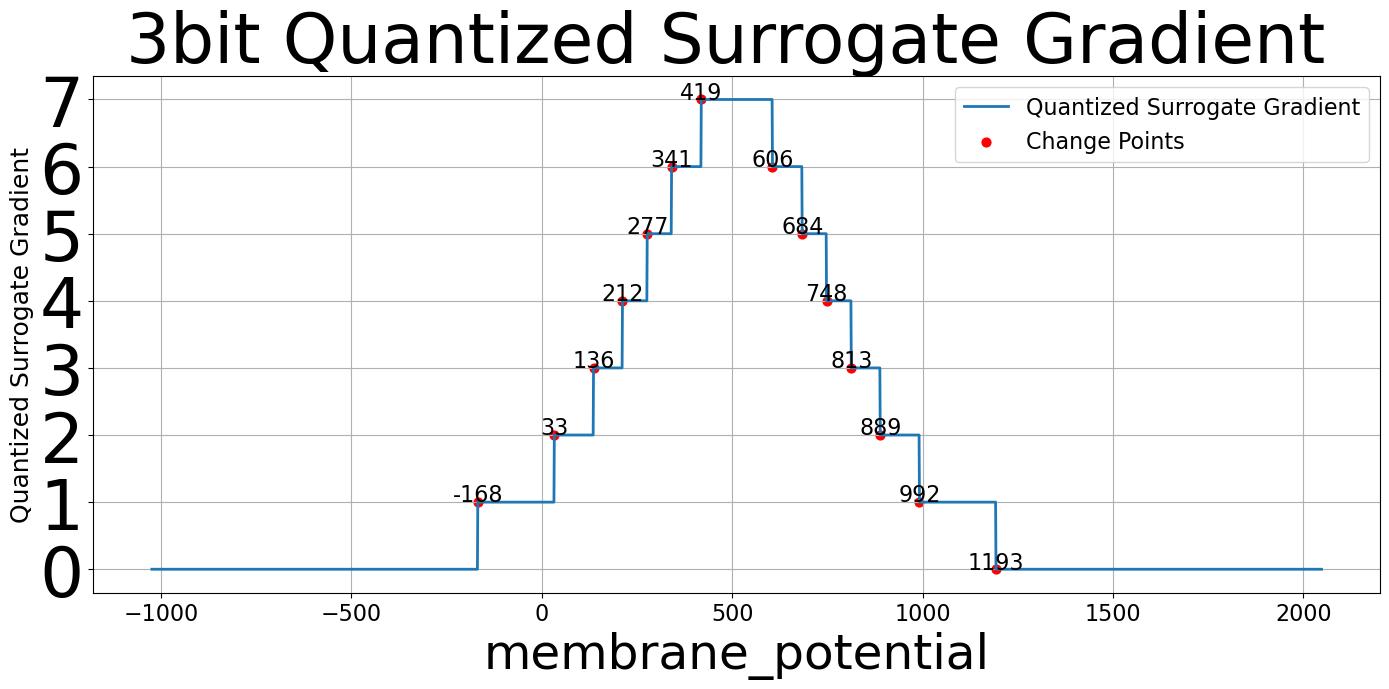

In [2]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
sg_width = 6.0
alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# Input range: from -1.5 to +1.5, include 0
step = 1 / 1024
v_vals_minus = torch.arange(0, -1.5 - step, -step)
v_vals_plus = torch.arange(step, 1.5 + step, step)
v_vals = torch.cat((v_vals_minus.flip(0), torch.tensor([0.0]), v_vals_plus))  # exact 0 included

# Surrogate gradient function
def sg(input):
    sig = torch.sigmoid(alpha * input)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized * 8

# Calculate quantized surrogate gradient
y = sg(v_vals)

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v_vals[change_indices] * 1024 + 512  # shift by +512
y_change = y[change_indices]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v_vals * 1024 + 512, y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()


# 밑 코드 쓰면 하이퍼파라미터로 x cut 바로 알 수 있음 

# alpha값 1024나눠줘야되는거알제?????
            sig = torch.sigmoid(alpha*v_minus_threshold/(2**(v_exp+10)))


## gesture


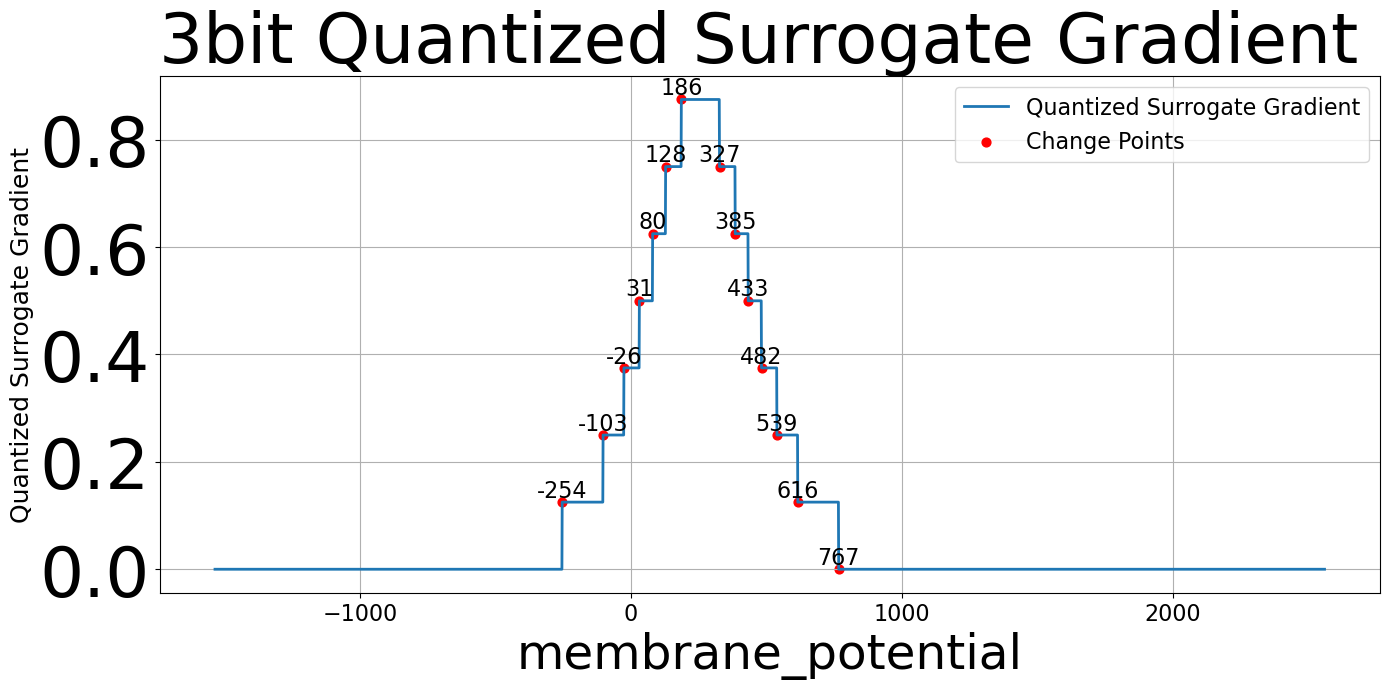

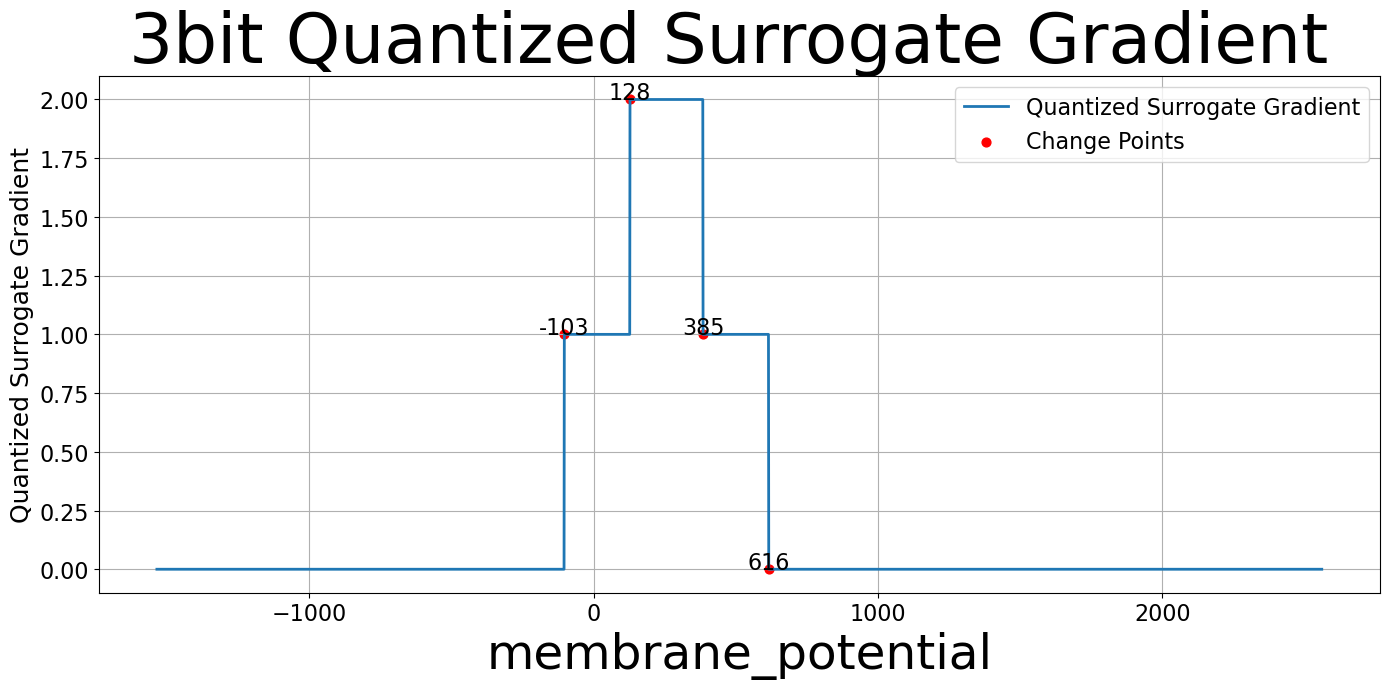

x_change_before_lr: tensor([-254., -103.,  -26.,   31.,   80.,  128.,  186.,  327.,  385.,  433.,
         482.,  539.,  616.,  767.])
x_change_after_lr: tensor([-103.,  128.,  385.,  616.])


In [4]:
import torch
import math
import matplotlib.pyplot as plt

# # Parameters
# weight_exp = -10
# threshold = 0.5
# sg_width = 6.0
# scale_v = 2**(weight_exp)
# v_bit = 15 # 이건 별로 상관없음
# dw_bit = 8
# learning_rate = 1/512

# Parameters
weight_exp = 0
threshold = 128
sg_width = 4.0 * 2 / 1024
scale_v = 2**(weight_exp)
v_bit = 15 # 이건 별로 상관없음
dw_bit = 8
learning_rate = 1.0






alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# v = torch.arange(-2**v_bit, 2**v_bit + 1) * scale_v
v = torch.arange((-2**v_bit)/16 +((2**(-weight_exp))*threshold), (2**v_bit + 1)/16 + ((2**(-weight_exp))*threshold) +1) * scale_v

# Surrogate gradient function
def sg(v):
    sig = torch.sigmoid(alpha * v)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized
y = sg(v)


# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 
y_change = y[change_indices]
x_change_before_lr = x_change.clone()
#설명약간

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()


y = learning_rate * y  # Apply learning rate
y = torch.clamp(torch.sign(y / scale_v) * torch.floor(torch.abs(y / scale_v) + 0.5), -2**(dw_bit-1) + 1, 2**(dw_bit-1) - 1) * scale_v

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 

x_change_after_lr = x_change.clone()
#설명약간

y_change = y[change_indices]
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() , f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


print(f'x_change_before_lr: {x_change_before_lr}')
print(f'x_change_after_lr: {x_change_after_lr}')

surrogate_x_cut = []
for i in range(len(x_change_before_lr)):
    x_change_before_lr

# [33,341,684,684,684, 684,684,684,684,684, 684,684,684,992]


## nmnist


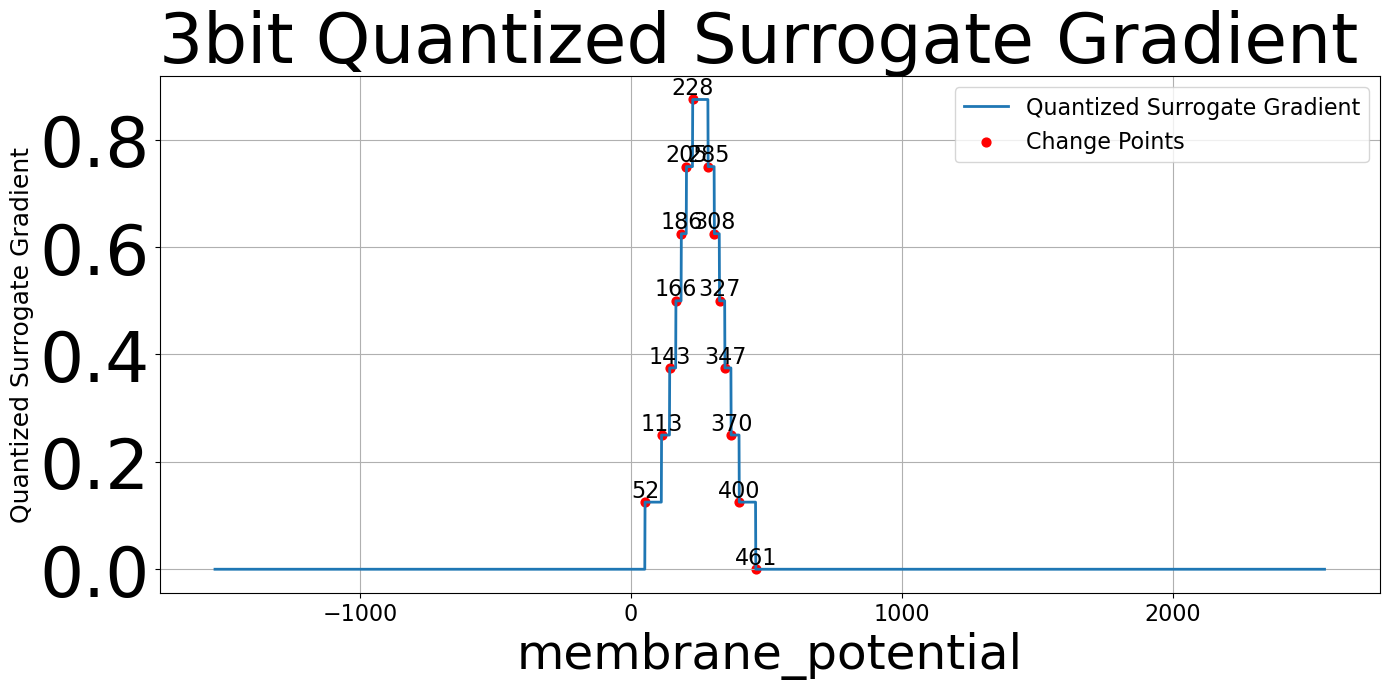

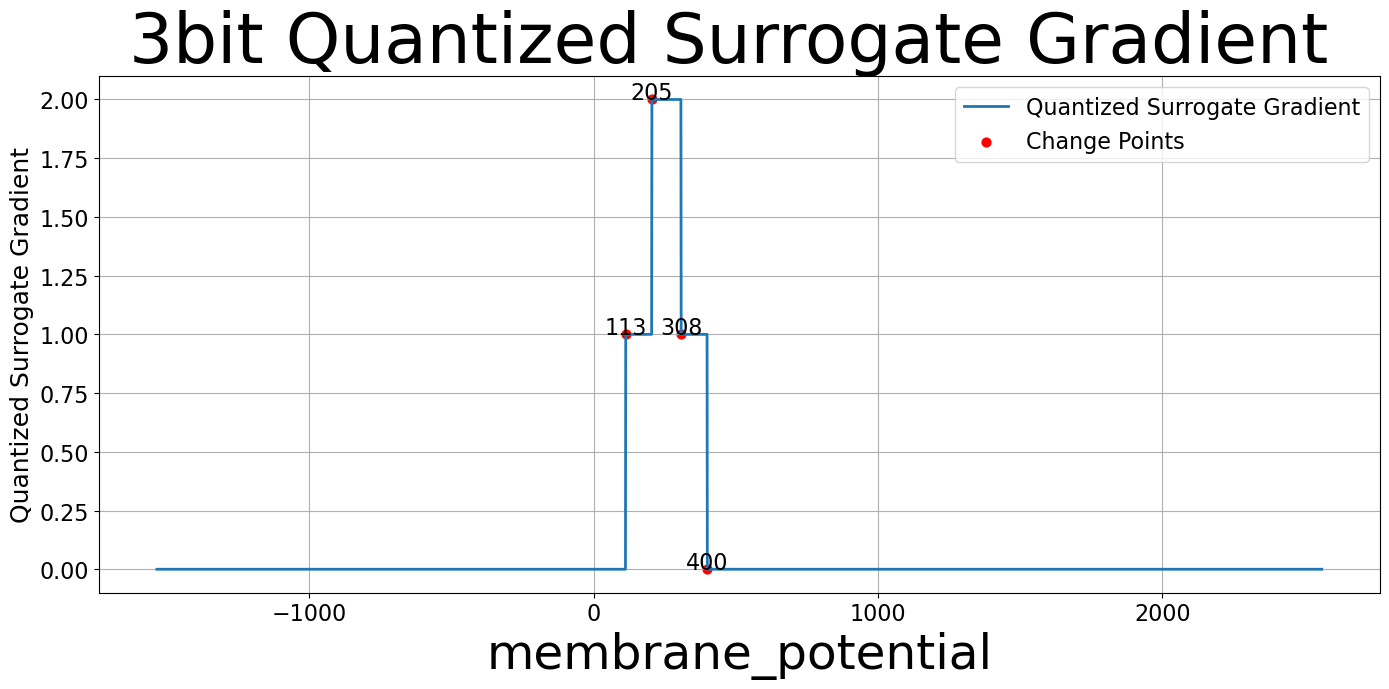

x_change_before_lr: tensor([ 52., 113., 143., 166., 186., 205., 228., 285., 308., 327., 347., 370.,
        400., 461.])
x_change_after_lr: tensor([113., 205., 308., 400.])


In [2]:
import torch
import math
import matplotlib.pyplot as plt

# # Parameters
# weight_exp = -9
# threshold = 0.5
# sg_width = 6.0
# scale_v = 2**(weight_exp)
# v_bit = 15 # 이건 별로 상관없음
# dw_bit = 8
# learning_rate = 1/256


# Parameters
weight_exp = 0
threshold = 256
sg_width = 10.0 * 2 / 1024
scale_v = 2**(weight_exp)
v_bit = 15 # 이건 별로 상관없음
dw_bit = 8
learning_rate = 2.0




alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# v = torch.arange(-2**v_bit, 2**v_bit + 1) * scale_v
v = torch.arange((-2**v_bit)/16 +((2**(-weight_exp))*threshold), (2**v_bit + 1)/16 + ((2**(-weight_exp))*threshold) +1) * scale_v
# v = torch.arange((-2**v_bit)/2 +((2**(-weight_exp))*threshold), (2**v_bit + 1)/2 + ((2**(-weight_exp))*threshold) +1) * scale_v

# Surrogate gradient function
def sg(v):
    sig = torch.sigmoid(alpha * v)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized
y = sg(v)


# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 
y_change = y[change_indices]
x_change_before_lr = x_change.clone()
#설명약간

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()


y = learning_rate * y  # Apply learning rate
y = torch.clamp(torch.sign(y / scale_v) * torch.floor(torch.abs(y / scale_v) + 0.5), -2**(dw_bit-1) + 1, 2**(dw_bit-1) - 1) * scale_v

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 

x_change_after_lr = x_change.clone()
#설명약간

y_change = y[change_indices]
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() , f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


print(f'x_change_before_lr: {x_change_before_lr}')
print(f'x_change_after_lr: {x_change_after_lr}')

surrogate_x_cut = []
for i in range(len(x_change_before_lr)):
    x_change_before_lr

# [33,341,684,684,684, 684,684,684,684,684, 684,684,684,992]


### nmnist unquantized


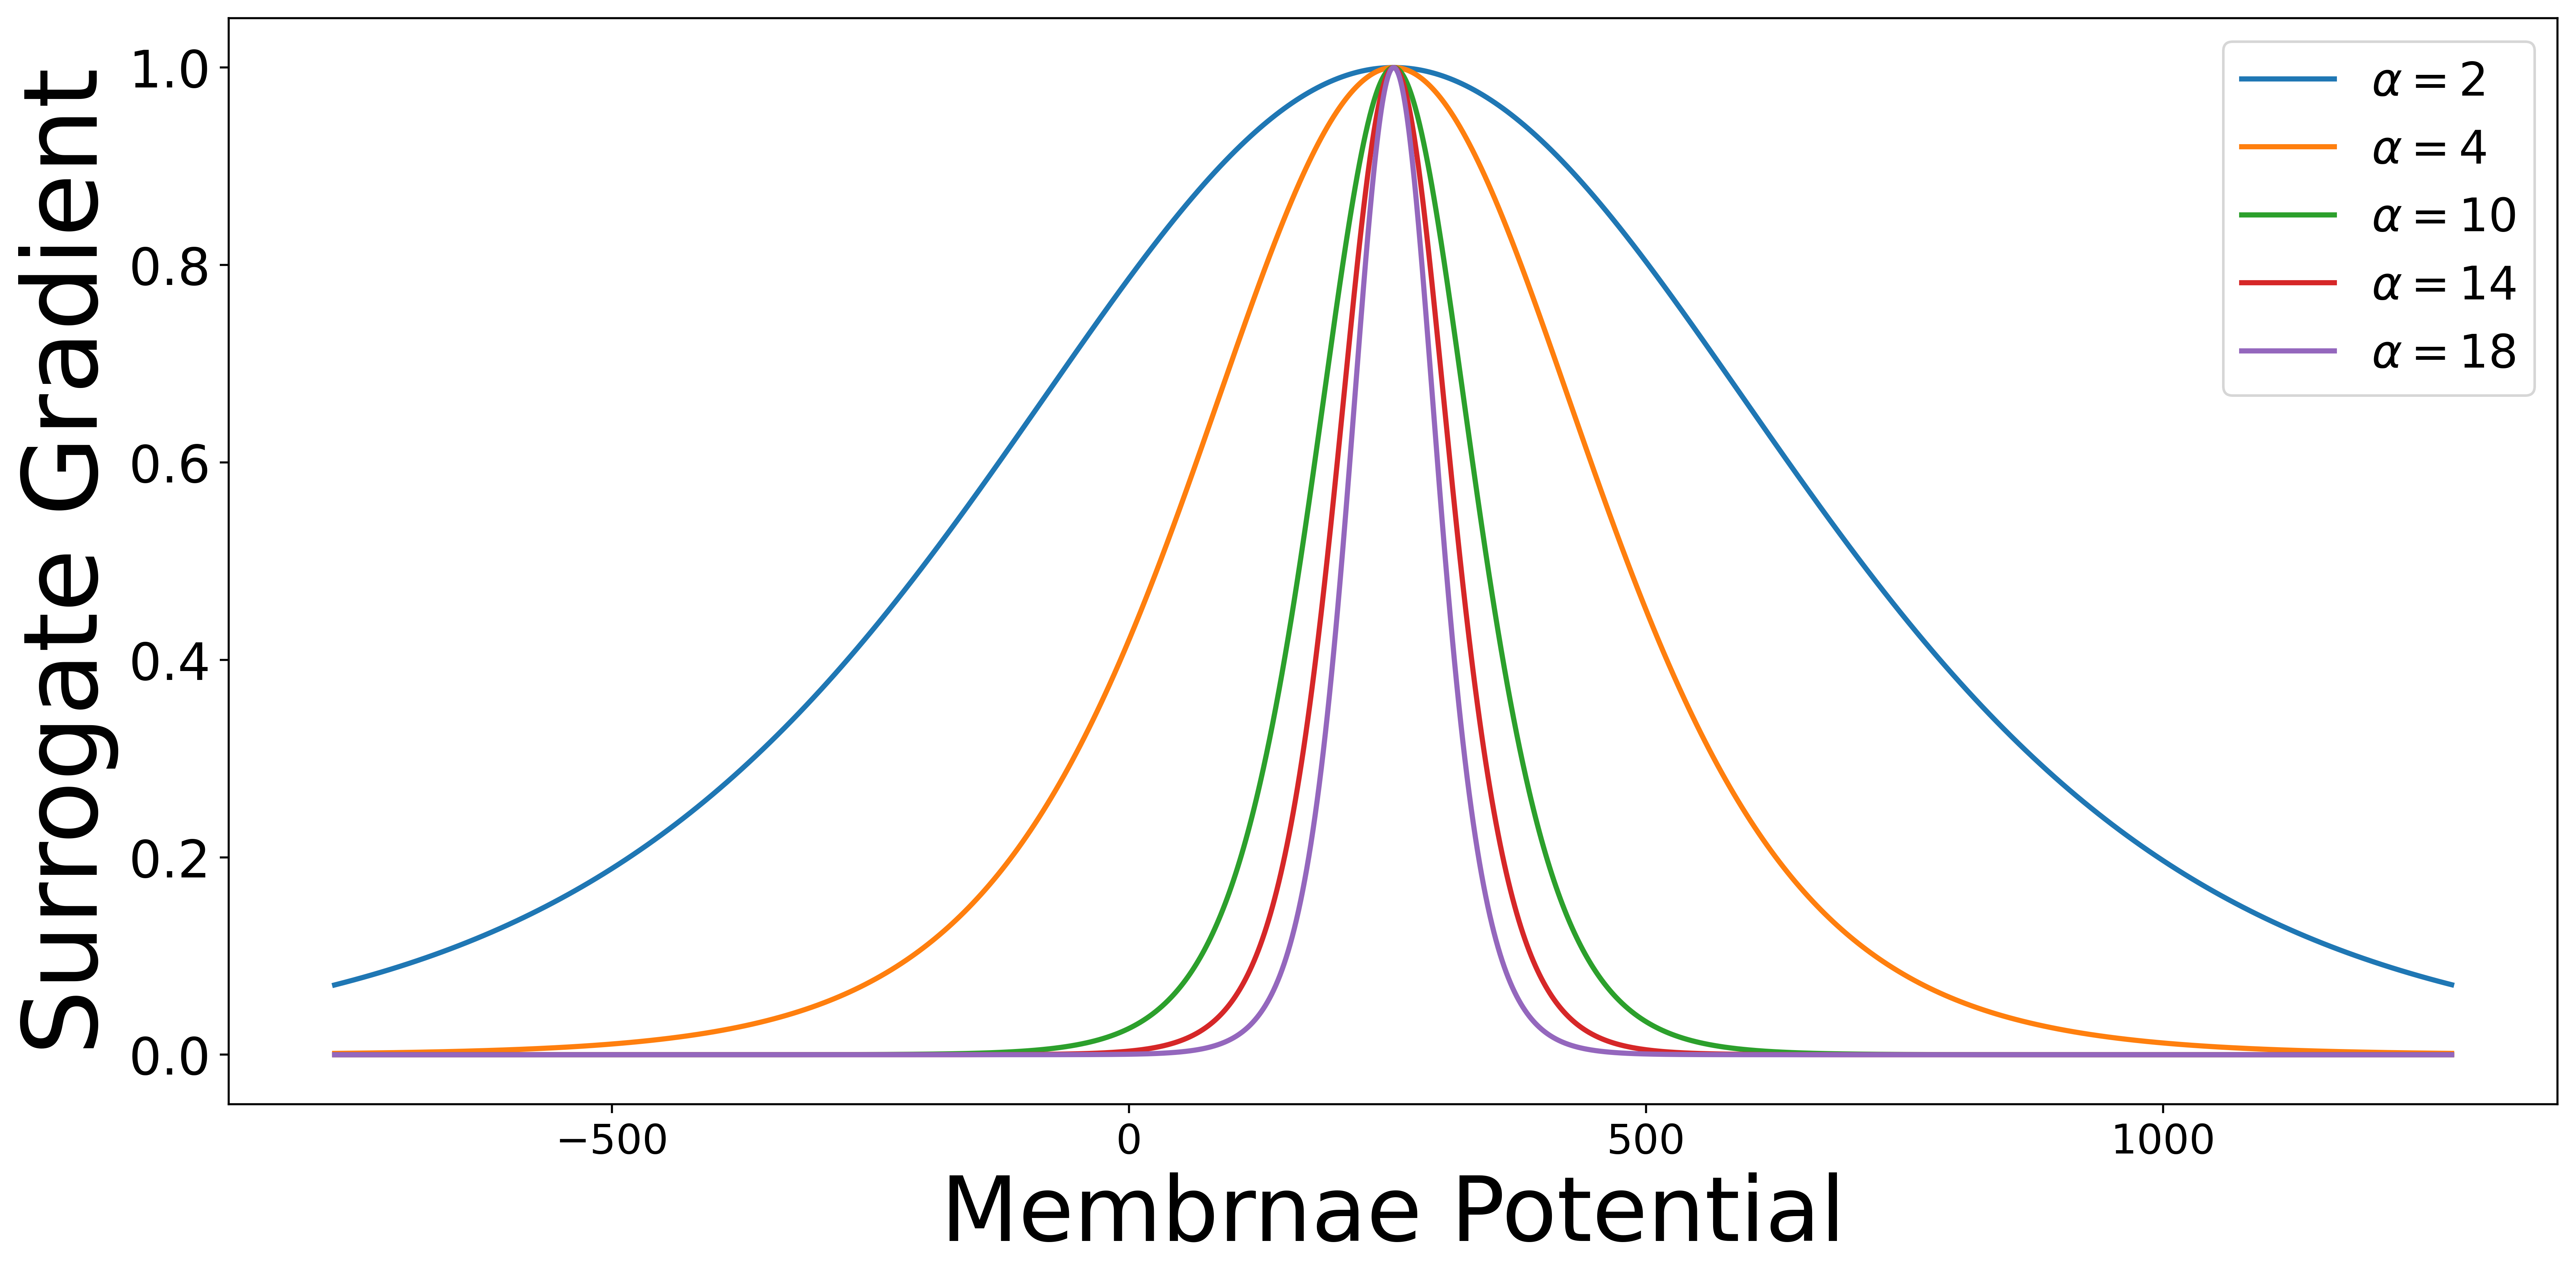

In [6]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
weight_exp = -9
threshold = 0.5
scale_v = 2**(weight_exp)
v_bit = 15

v = torch.arange((-(2**v_bit))/32, (2**v_bit)/32 ) * scale_v

def sg(v, alpha):
    sig = torch.sigmoid(alpha * v)
    return 4.0 * sig * (1 - sig)

# Different sg_width values
sg_width_list = [2, 4, 10, 14, 18]

plt.figure(figsize=(14, 7), dpi=500)

for alpha in sg_width_list:
    y = sg(v, alpha)
    plt.plot(
        v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold),
        y,
        label=fr"$\alpha = {alpha}$",
        linewidth=2
    )

plt.xlabel("Membrnae Potential", fontsize=35)
plt.ylabel("Surrogate Gradient", fontsize=40)
# plt.title("Surrogate Gradient Comparison", fontsize=50)
# plt.grid(True)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


## n-tidigits


threshoold in hw 1024.0


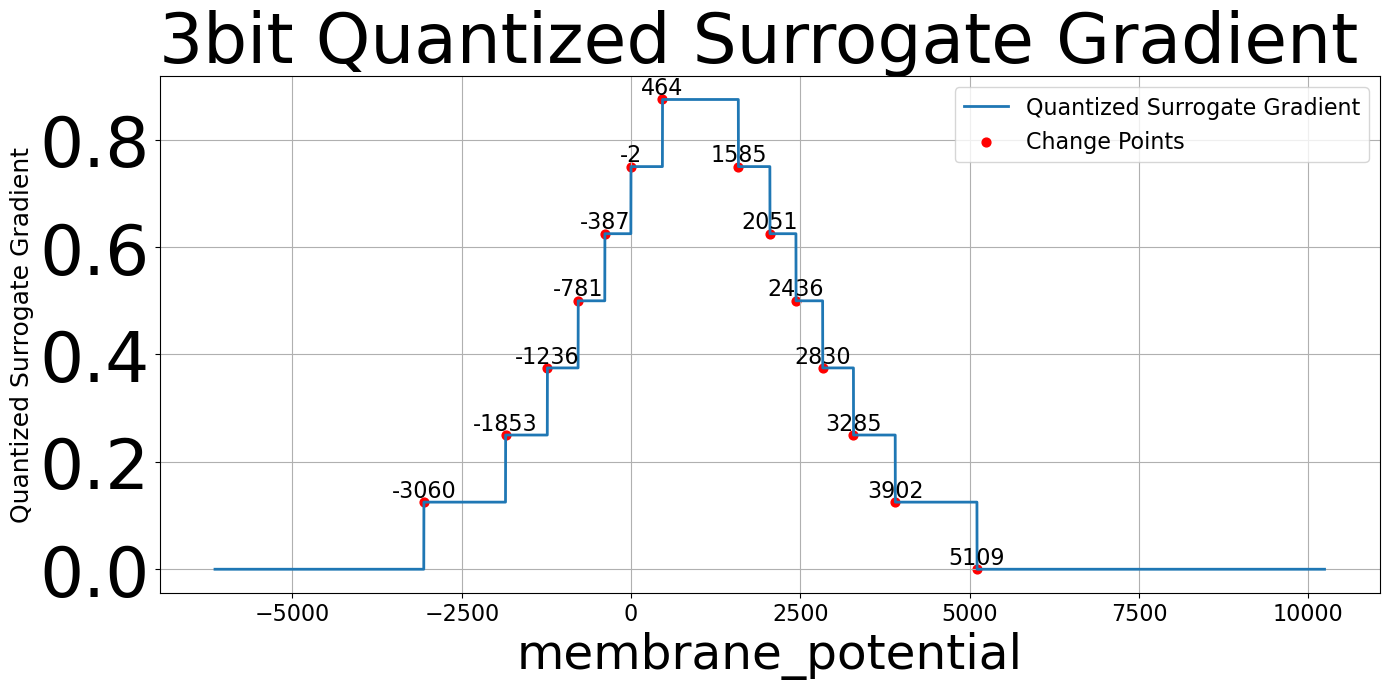

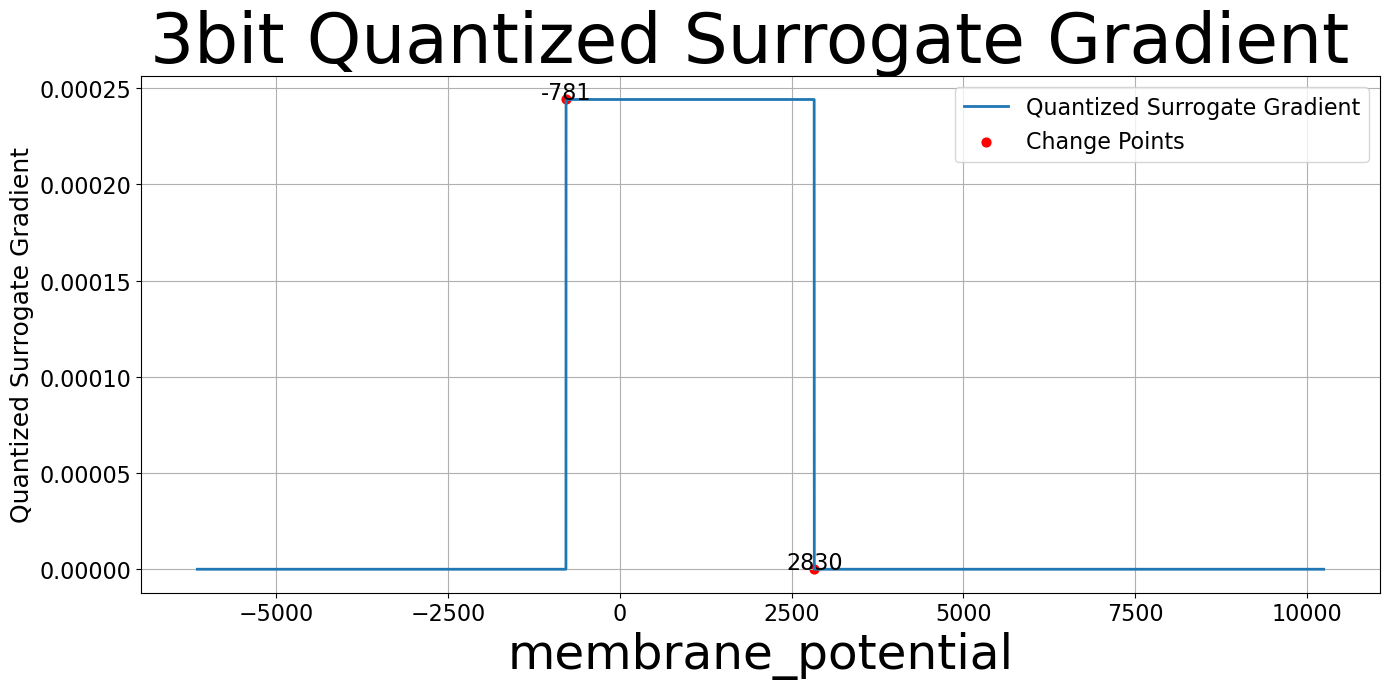

x_change_before_lr: tensor([-3.0600e+03, -1.8530e+03, -1.2360e+03, -7.8100e+02, -3.8700e+02,
        -2.0000e+00,  4.6400e+02,  1.5850e+03,  2.0510e+03,  2.4360e+03,
         2.8300e+03,  3.2850e+03,  3.9020e+03,  5.1090e+03])
x_change_after_lr: tensor([-781., 2830.])


In [3]:
import torch
import math
import matplotlib.pyplot as plt

# Parameters
weight_exp = -12
threshold = 0.25
sg_width = 4.0
scale_v = 2**(weight_exp)
v_bit = 17 # 이건 별로 상관없음
dw_bit = 8
learning_rate = 1/4096


print(f'threshoold in hw {threshold*(2**(-weight_exp))}')


alpha = sg_width
sg_bit = 4
sg_temp_max = 1.0
sg_temp_max -= 2 ** (-(sg_bit - 1))
scale_sg_temp = 2 ** math.ceil(math.log2(sg_temp_max / (2 ** (sg_bit - 1) - 1)))

# v = torch.arange(-2**v_bit, 2**v_bit + 1) * scale_v
v = torch.arange((-2**v_bit)/16 +((2**(-weight_exp))*threshold), (2**v_bit + 1)/16 + ((2**(-weight_exp))*threshold) +1) * scale_v

# Surrogate gradient function
def sg(v):
    sig = torch.sigmoid(alpha * v)
    sg_temp = 4.0 * sig * (1 - sig)  # smooth surrogate gradient (max 1.0)
    sg_temp *= sg_temp_max
    sg_temp_quantized = torch.clamp((sg_temp / scale_sg_temp).round(),
                                    -2 ** (sg_bit - 1) + 1, 2 ** (sg_bit - 1) - 1) * scale_sg_temp
    return sg_temp_quantized
y = sg(v)


# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 
y_change = y[change_indices]
x_change_before_lr = x_change.clone()
#설명약간

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() + 0.01, f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=50)
plt.tight_layout()
plt.show()


y = learning_rate * y  # Apply learning rate
y = torch.clamp(torch.sign(y / scale_v) * torch.floor(torch.abs(y / scale_v) + 0.5), -2**(dw_bit-1) + 1, 2**(dw_bit-1) - 1) * scale_v

# Find where y changes
change_indices = torch.nonzero(y[1:] != y[:-1], as_tuple=False).squeeze() + 1
x_change = v[change_indices] * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold)  # shift by +512 

x_change_after_lr = x_change.clone()
#설명약간

y_change = y[change_indices]
# Plotting
plt.figure(figsize=(14, 7))
plt.plot(v * (2**(-weight_exp)) + ((2**(-weight_exp))*threshold), y, label='Quantized Surrogate Gradient', linewidth=2)
plt.scatter(x_change, y_change, color='red', label='Change Points', s=40)

# Annotate change points
for x, y_val in zip(x_change, y_change):
    plt.text(x.item(), y_val.item() , f'{x.item():.0f}',
             fontsize=16, ha='center', rotation=0)

plt.xlabel("membrane_potential", fontsize=35)
plt.ylabel("Quantized Surrogate Gradient", fontsize=18)
plt.title("3bit Quantized Surrogate Gradient ", fontsize=50)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


print(f'x_change_before_lr: {x_change_before_lr}')
print(f'x_change_after_lr: {x_change_after_lr}')

surrogate_x_cut = []
for i in range(len(x_change_before_lr)):
    x_change_before_lr

# [33,341,684,684,684, 684,684,684,684,684, 684,684,684,992]


In [ ]:
for i in range(66):  # 0 ~ 65
    print(f"""    PBNT_18  PAD_IN_input_streaming_data_i_{i} (
        .PAD(input_streaming_data_i[{i}]),
        .A(1'b0),
        .Y(w_input_streaming_data_i[{i}]),
        .IE(1'b1), .OE(1'b0),
        .DRIVE0(1'b1), .DRIVE1(1'b1), .DRIVE2(1'b1),
        .RTN(), .SPS(), .POE(1'b1), .PO(), .PDN(1'b1), .PUN(1'b1), .ASRCN1V8(), .ASRCP1V8()
    );""")


    PBNT_18  PAD_IN_input_streaming_data_i_0 (
        .PAD(input_streaming_data_i[0]),
        .A(1'b0),
        .Y(w_input_streaming_data_i[0]),
        .IE(1'b1), .OE(1'b0),
        .DRIVE0(1'b1), .DRIVE1(1'b1), .DRIVE2(1'b1),
        .RTN(), .SPS(), .POE(1'b1), .PO(), .PDN(1'b1), .PUN(1'b1), .ASRCN1V8(), .ASRCP1V8()
    );
    PBNT_18  PAD_IN_input_streaming_data_i_1 (
        .PAD(input_streaming_data_i[1]),
        .A(1'b0),
        .Y(w_input_streaming_data_i[1]),
        .IE(1'b1), .OE(1'b0),
        .DRIVE0(1'b1), .DRIVE1(1'b1), .DRIVE2(1'b1),
        .RTN(), .SPS(), .POE(1'b1), .PO(), .PDN(1'b1), .PUN(1'b1), .ASRCN1V8(), .ASRCP1V8()
    );
    PBNT_18  PAD_IN_input_streaming_data_i_2 (
        .PAD(input_streaming_data_i[2]),
        .A(1'b0),
        .Y(w_input_streaming_data_i[2]),
        .IE(1'b1), .OE(1'b0),
        .DRIVE0(1'b1), .DRIVE1(1'b1), .DRIVE2(1'b1),
        .RTN(), .SPS(), .POE(1'b1), .PO(), .PDN(1'b1), .PUN(1'b1), .ASRCN1V8(), .ASRCP1V8()
    );
    PBNT_18  

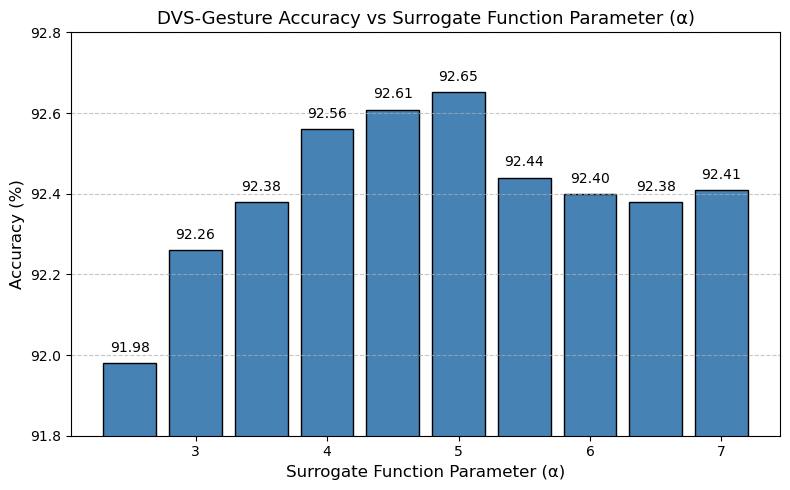

In [14]:
import matplotlib.pyplot as plt

# 데이터 입력
sg_width = [2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
gesture = [91.98, 92.26, 92.38, 92.56, 92.6087, 92.6516, 92.44, 92.4, 92.38, 92.41]

# 막대그래프 그리기
plt.figure(figsize=(8,5))
plt.bar(sg_width, gesture, width=0.4, color='steelblue', edgecolor='black')

# 그래프 제목 및 축 레이블
plt.title("DVS-Gesture Accuracy vs Surrogate Function Parameter (α)", fontsize=13)
plt.xlabel("Surrogate Function Parameter (α)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)

# y축 범위 및 그리드 설정
plt.ylim(91.8, 92.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 각 막대 위에 정확도 수치 표시
for x, y in zip(sg_width, gesture):
    plt.text(x, y + 0.02, f"{y:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [2]:
import numpy as np

# 20×10 matrix A
A = np.array([
    [-1, 2, 2, 5, 6, -2, 1, -6, 4, 8],
    [9,-4,5,-6,2,1,6,4,-8,7],
    [-5,3,1,2,-3,2,-4,5,8,7],
    [9,5,3,1,2,3,4,-5,7,9],
    [5,3,2,-1,5,4,6,8,4,6],
    [5,8,3,5,-7,9,5,-3,2,1],
    [6,-4,8,7,9,5,3,2,-1,6],
    [4,5,-8,4,5,6,2,3,1,4],
    [-5,6,8,-7,9,5,1,2,4,6],
    [5,7,8,-5,6,3,4,3,2,1],
    [6,4,-5,8,7,9,5,1,-5,6],
    [2,1,-3,0,-3,1,-5,4,6,8],
    [-7,0,6,-4,0,6,-4,5,2,3],
    [-1,0,5,4,6,-7,5,0,1,2],
    [3,5,4,6,0,6,-4,5,-1,3],
    [0,3,-2,5,4,-6,0,2,1,6],
    [0,0,6,4,5,6,-7,8,5,6],
    [4,-5,3,2,4,-4,5,2,3,0],
    [-8,6,-5,2,1,3,5,4,-6,4],
    [5,3,2,-4,0,6,-4,8,4,6],
])

# 10×1 vector B
B = np.array([0.1, 0.2, -0.1, 0.2, 0.3, 0.4, -0.2, -0.1, 0.9, 0.3])

# MATMUL
C = A.dot(B)

print(C)

[ 8.5 -7.3  9.9 12.3  7.2  5.7  5.2  8.3  8.2  4.1  5.4  8.6  3.3 -0.3
  4.8  3.1 11.   0.6 -2.8  7.9]
